In [1]:
!nvidia-cdl

Driver version: 510.85.02
------------------- Device 0 -------------------
Name: NVIDIA GeForce RTX 3090 Ti
Memory usage:  4407MiB / 24564MiB
Temperature: 23C
Running processes not found

------------------- Device 1 -------------------
Name: NVIDIA GeForce RTX 3090 Ti
Memory usage:   316MiB / 24564MiB
Temperature: 28C
Running processes not found

------------------- Device 2 -------------------
Name: NVIDIA GeForce RTX 3090 Ti
Memory usage: 13837MiB / 24564MiB
Temperature: 32C
Running processes not found

------------------- Device 3 -------------------
Name: NVIDIA GeForce RTX 3090 Ti
Memory usage:   316MiB / 24564MiB
Temperature: 23C
Running processes not found

------------------- Device 4 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:  9196MiB / 11264MiB
Temperature: 22C
Running processes not found

------------------- Device 5 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:  9188MiB / 11264MiB
Temperature: 22C
Running processes not found



In [9]:
!pip install -U requests
!pip install spacy
!pip install sentencepiece
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.1 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flair 0.11.3 requires bpemb>=0.3.2, which is not installed.
flair 0.11.3 requires conllu>=4.0, which is not installed.
flair 0.11.3 requires deprecated>=1.2.4, which is not installed.
flair 0.11.3 requires ftfy, which is not installed.
flair 0.11.3 requires gensim>=3.4.0, which is not installed.
flair 0.11.3 requires huggingface-hub, which is not installed.
flair 0.11.3 requires hyperopt>=0.2.7, which is not installed.
flair 0.11.3 requires janome, which is not installed.
flair 0.11.3 requires konoha<5.0.0,>=4.0.0, which is not installed.
flair 0.11.3 requires langdetect, which is not installed.
flair 0.11.3 requires mpld3==0.3, which is not installed.
flair 0.11.3 requires pptree, which is not installed.
flair 0.11.3 requires s

In [91]:
import numpy as np
import scipy.stats
import math
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from tqdm import tqdm
import pickle
from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
from itertools import compress

import en_core_web_sm
import spacy
import warnings
warnings.filterwarnings("ignore")

# spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

#nlp = en_core_web_sm.load()
client = wikidata.client.Client()

In [3]:
#! wget https://dl.fbaipublicfiles.com/GENRE/lang_title2wikidataID-normalized_with_redirect.pkl
    
with open("lang_title2wikidataID-normalized_with_redirect.pkl", "rb") as f:
    lang_title2wikidataID = pickle.load(f)

In [4]:
def get_description_name(idd):
    '''
    This function returns a name of an entity and its description given WikiData id
    
        input:  (str) wikidata id, e.x. 'Q2'
        output: (str) concatenated 'name, description' of a given entity
    '''
    entity = client.get(idd, load=True)
    name = "None"
    description = "None"
    try:
        name = entity.data["labels"]["en"]["value"]
        
    except:
        pass
    return name


def text_to_id(x):
    #splits = x.split(" >> ")
    if len(x) > 1:
        return max(lang_title2wikidataID[tuple(reversed(x))], key=lambda y: int(y[1:]))
    else:
        return 'Empty'
    
def from_text_to_id(x):
    return list(lang_title2wikidataID[("en", x)])[0]
    
    
    
### For top k sample
    
def getScores(ids, scores, pad_token_id):
    """get sequence scores from model.generate output"""
    scores = torch.stack(scores, dim=1)
    log_probs = torch.log_softmax(scores, dim=2)
    # remove start token
    ids = ids[:,1:]
    # gather needed probs
    x = ids.unsqueeze(-1).expand(log_probs.shape)
    needed_logits = torch.gather(log_probs, 2, x)
    final_logits = needed_logits[:, :, 0]
    padded_mask = (ids == pad_token_id)
    final_logits[padded_mask] = 0
    final_scores = final_logits.sum(dim=-1)
    return final_scores.cpu().detach().numpy()

def topkSample(input, model, tokenizer, 
                num_samples=5,
                num_beams=1,
                max_output_length=128):
    tokenized = tokenizer(input, return_tensors="pt")
    tokenized.to(device)
    out = model.generate(**tokenized,
                        do_sample=True,
                        num_return_sequences = num_samples,
                        num_beams = num_beams,
                        eos_token_id = tokenizer.eos_token_id,
                        pad_token_id = tokenizer.pad_token_id,
                        output_scores = True,
                        return_dict_in_generate=True,
                        max_length=max_output_length,)
    out_tokens = out.sequences
    out_str = tokenizer.batch_decode(out_tokens, skip_special_tokens=True)
    out_scores = getScores(out_tokens, out.scores, tokenizer.pad_token_id)
    
    pair_list = [(x[0], x[1]) for x in zip(out_str, out_scores)]
    sorted_pair_list = sorted(pair_list, key=lambda x:x[1], reverse=True)
    return sorted_pair_list

def greedyPredict(input, model, tokenizer):
    input_ids = tokenizer([input], return_tensors="pt").input_ids
    out_tokens = model.generate(input_ids)
    out_str = tokenizer.batch_decode(out_tokens, skip_special_tokens=True)
    return out_str[0]


def check_t5_sq(t5_tok, t5_qa_model):
    
    sq_test_data = np.load("simple_questions_test.npy")
    questions = sq_test_data[:,3]


    answers = []
    for i in tqdm(range(len(questions))):
        input_ids = t5_tok(questions[i], return_tensors="pt").input_ids
        input_ids = input_ids.to(device)
        gen_output = t5_qa_model.generate(input_ids)[0]
        answers.append(gen_output)


    preds_sq = []
    for x in answers:
        preds_sq.append(t5_tok.decode(x, skip_special_tokens=True))


    preds_id_sq = []
    for i in range(len(preds_sq)):
        try:
            x = from_text_to_id(preds_sq[i])
        except:
            x = "None"

        preds_id_sq.append(x)

    right_sq = 0
    for i in tqdm(range(len(preds_id_sq))):
        if preds_id_sq[i] == sq_test_data[i,2]:
            right_sq += 1
        else:
            pass

    acc = right_sq/len(preds_id_sq)
    
    return acc, preds_id_sq

softmax = nn.Softmax()

In [25]:
t5_qa_model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-xl-ssm-nq")
t5_tok = AutoTokenizer.from_pretrained("google/t5-xl-ssm-nq")

# t5_qa_model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-3b-ssm")#"google/t5-11b-ssm-tqa")
# t5_tok = AutoTokenizer.from_pretrained("google/t5-3b-ssm")

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
t5_qa_model.to(device)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.4G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 2048)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 2048)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=2048, out_features=2048, bias=False)
              (k): Linear(in_features=2048, out_features=2048, bias=False)
              (v): Linear(in_features=2048, out_features=2048, bias=False)
              (o): Linear(in_features=2048, out_features=2048, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
              (wi_1): Linear(in_features=2048, out_features=5120, bias=False)
       

In [26]:
# data
rubq_test = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")
rubq_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)

entities_test_rubq = np.load("entities_test_rubq.npy")
rubq_test_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)
rubq_test = pd.DataFrame({"subject":entities_test_rubq, "question":rubq_test})

In [27]:
question = rubq_test.question[0]
question

'What can cause a tsunami?'

In [92]:
def predict_and_proba(question, model, tokenizer, device, num_beams = 10, max_sequence_length = 32):
    """This function generates sequence = answer on given question
    
    1) it encodes qustion using tokenizer
    2) converts tokenized text to device
    3) generate answer with dredefined beam size using tokenized text
    4) as output we receive answers and their probabilities
    
    """
    
    input_ids = tokenizer([question], return_tensors="pt").input_ids
    input_ids = input_ids.to(device)

    out = model.generate(input_ids,
                         num_return_sequences = num_beams,
                         num_beams = num_beams,
                         eos_token_id = tokenizer.eos_token_id,
                         pad_token_id = tokenizer.pad_token_id,
                         output_scores = True,
                         return_dict_in_generate=True,
                         early_stopping=True,
                         max_length=max_sequence_length)
    
    prediction = [tokenizer.decode(out.sequences[i], skip_special_tokens=True) for i in range(num_beams)]
    probs = softmax(out.sequences_scores)
    
    return prediction, probs

In [178]:
sample_questions = len(rubq_test)
three_quest = list(rubq_test.question)[:sample_questions]

In [179]:
result = [predict_and_proba(three_quest[i], model = t5_qa_model, tokenizer=t5_tok, device=device) for i in range(sample_questions)]


In [180]:
predictions = [i[0] for i in result]
probas = [i[1] for i in result]
probas = [i.detach().to("cpu") for i in probas]

# Experiments with uncertainty on a single model (Entropy, Maxprob, Delta)

### Entropy

In [182]:
num_quantiles = 20

quants = [thresh / num_quantiles for thresh in range(1, num_quantiles+1)]
entropies = [scipy.stats.entropy(i) for i in probas]
thresholds_entropy = [np.quantile(entropies, q) for q in quants]

accuracy_for_each_topk = []

#top_k pred
for top_k in [1, 2, 5, 10]:
    
    accuracy_for_each_quantile = {}

    for quantile in range(num_quantiles):

        # list of predictions
        list_of_predictions = list(compress(predictions, entropies <= thresholds_entropy[quantile]))
        
        #list of correct answers
        list_of_correct_answers = list(compress(rubq_test_answers[:sample_questions], entropies <= thresholds_entropy[quantile]))
        
        # choose top k predictions
        top_k_list_of_predictions = [i[:top_k] for i in list_of_predictions]

        top_k_list_of_predicted_ids= []
        for sample in top_k_list_of_predictions:
            new = []
            for prediction in sample:
                try:
                    x = from_text_to_id(prediction)
                except:
                    x = "None"
                new.append(x)

            top_k_list_of_predicted_ids.append(new)


        right = 0
        for i in range(len(list_of_correct_answers)):
            if any(item in top_k_list_of_predicted_ids[i] for item in list_of_correct_answers[i]):
                right += 1
            else:
                pass

        accuracy = np.round(right/len(list_of_correct_answers), 4)*100
        print(f"Top-{top_k} accuracy on the {(quantile+1)*(int(100/num_quantiles))}% the most confident from the entropy point of view = {accuracy}%")

        accuracy_for_each_quantile[(quantile+1)*(int(100/num_quantiles))] = accuracy
        accuracy_for_each_topk.append(accuracy_for_each_quantile)
        
    print("\n")









Top-1 accuracy on the 5% the most confident from the entropy point of view = 76.67%
Top-1 accuracy on the 10% the most confident from the entropy point of view = 71.43%
Top-1 accuracy on the 15% the most confident from the entropy point of view = 69.1%
Top-1 accuracy on the 20% the most confident from the entropy point of view = 69.75%
Top-1 accuracy on the 25% the most confident from the entropy point of view = 70.37%
Top-1 accuracy on the 30% the most confident from the entropy point of view = 66.57%
Top-1 accuracy on the 35% the most confident from the entropy point of view = 64.34%
Top-1 accuracy on the 40% the most confident from the entropy point of view = 61.260000000000005%
Top-1 accuracy on the 45% the most confident from the entropy point of view = 57.68%
Top-1 accuracy on the 50% the most confident from the entropy point of view = 53.959999999999994%
Top-1 accuracy on the 55% the most confident from the entropy point of view = 50.77%
Top-1 accuracy on the 60% the most confid

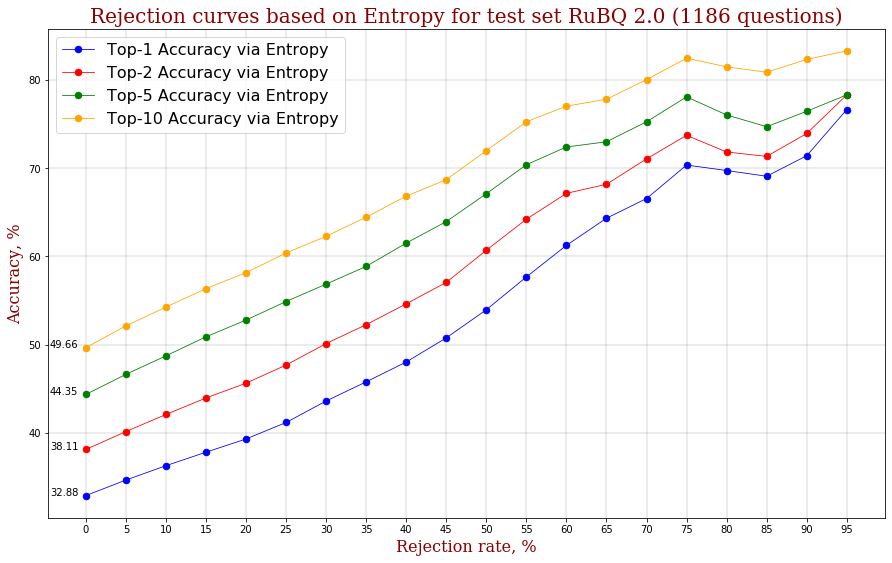

In [244]:
plt.figure(figsize = (15, 9))
plt.title("Rejection curves based on Entropy for test set RuBQ 2.0 (1186 questions)", fontdict=font_title)

font = {'family': 'serif',
            'color': 'darkred',
            'weight': 'normal',
            'size': 16
            }

font_title = {'family': 'serif',
              'color': 'darkred',
              'weight': 'normal',
              'size': 20
              }

plt.xlabel("Rejection rate, %", fontdict=font)
plt.ylabel("Accuracy, %", fontdict=font)
plt.xticks(ticks=np.arange(0, 100, step=5))
plt.grid(color='black', linewidth=0.15)


plt.plot(100 - np.array(list(accuracy_for_each_topk[:num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[:num_quantiles][0].values())),
         label=f"Top-{1} Accuracy via Entropy", c="blue", marker='.', markersize=13, linewidth=0.8);

plt.plot(100 - np.array(list(accuracy_for_each_topk[num_quantiles:2*num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[num_quantiles:2*num_quantiles][0].values())),
         label=f"Top-{2} Accuracy via Entropy", c="red", marker='.', markersize=13, linewidth=0.8);

plt.plot(100 - np.array(list(accuracy_for_each_topk[2*num_quantiles:3*num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[2*num_quantiles:3*num_quantiles][0].values())),
         label=f"Top-{5} Accuracy via Entropy", c="green", marker='.', markersize=13, linewidth=0.8);

plt.plot(100 - np.array(list(accuracy_for_each_topk[3*num_quantiles:4*num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[3*num_quantiles:4*num_quantiles][0].values())),
         label=f"Top-{10} Accuracy via Entropy", c="orange", marker='.', markersize=13, linewidth=0.8);


accuracy_on_full_data_top_1 = np.array(list(accuracy_for_each_topk[:num_quantiles][0].values()))[-1]
accuracy_on_full_data_top_2 = np.array(list(accuracy_for_each_topk[num_quantiles:2*num_quantiles][0].values()))[-1]
accuracy_on_full_data_top_5 = np.array(list(accuracy_for_each_topk[2*num_quantiles:3*num_quantiles][0].values()))[-1]
accuracy_on_full_data_top_10 = np.array(list(accuracy_for_each_topk[3*num_quantiles:4*num_quantiles][0].values()))[-1]

plt.annotate("{}".format(np.round(accuracy_on_full_data_top_1, 2)), (0 - 4.5, accuracy_on_full_data_top_1));
plt.annotate("{}".format(np.round(accuracy_on_full_data_top_2, 2)), (0 - 4.5, accuracy_on_full_data_top_2));
plt.annotate("{}".format(np.round(accuracy_on_full_data_top_5, 2)), (0 - 4.5, accuracy_on_full_data_top_5));
plt.annotate("{}".format(np.round(accuracy_on_full_data_top_10, 2)), (0 - 4.5, accuracy_on_full_data_top_10));

plt.legend(fontsize=16);



# Maxprob

In [254]:
num_quantiles = 20

quants = [thresh / num_quantiles for thresh in range(1, num_quantiles+1)]
max_probs = [i[0] for i in probas]
thresholds_maxprob = [np.quantile(max_probs, q) for q in quants]
thresholds_maxprob = thresholds_maxprob[::-1]

accuracy_for_each_topk = []

#top_k pred
for top_k in [1, 2, 5, 10]:
    
    accuracy_for_each_quantile = {}

    for quantile in range(num_quantiles):

        # list of predictions
        list_of_predictions = list(compress(predictions, max_probs >= thresholds_maxprob[quantile]))
        
        #list of correct answers
        list_of_correct_answers = list(compress(rubq_test_answers[:sample_questions], max_probs >= thresholds_maxprob[quantile]))
        
        # choose top k predictions
        top_k_list_of_predictions = [i[:top_k] for i in list_of_predictions]

        top_k_list_of_predicted_ids= []
        for sample in top_k_list_of_predictions:
            new = []
            for prediction in sample:
                try:
                    x = from_text_to_id(prediction)
                except:
                    x = "None"
                new.append(x)

            top_k_list_of_predicted_ids.append(new)


        right = 0
        for i in range(len(list_of_correct_answers)):
            if any(item in top_k_list_of_predicted_ids[i] for item in list_of_correct_answers[i]):
                right += 1
            else:
                pass

        accuracy = np.round(right/len(list_of_correct_answers), 4)*100
        print(f"Top-{top_k} accuracy on the {(quantile+1)*(int(100/num_quantiles))}% the most confident from the Maxprob point of view = {accuracy}%")

        accuracy_for_each_quantile[(quantile+1)*(int(100/num_quantiles))] = accuracy
        accuracy_for_each_topk.append(accuracy_for_each_quantile)
        
    print("\n")









Top-1 accuracy on the 5% the most confident from the Maxprob point of view = 100.0%
Top-1 accuracy on the 10% the most confident from the Maxprob point of view = 76.67%
Top-1 accuracy on the 15% the most confident from the Maxprob point of view = 73.11%
Top-1 accuracy on the 20% the most confident from the Maxprob point of view = 71.91%
Top-1 accuracy on the 25% the most confident from the Maxprob point of view = 69.75%
Top-1 accuracy on the 30% the most confident from the Maxprob point of view = 69.36%
Top-1 accuracy on the 35% the most confident from the Maxprob point of view = 68.82000000000001%
Top-1 accuracy on the 40% the most confident from the Maxprob point of view = 64.58%
Top-1 accuracy on the 45% the most confident from the Maxprob point of view = 60.84%
Top-1 accuracy on the 50% the most confident from the Maxprob point of view = 57.120000000000005%
Top-1 accuracy on the 55% the most confident from the Maxprob point of view = 54.13%
Top-1 accuracy on the 60% the most confid

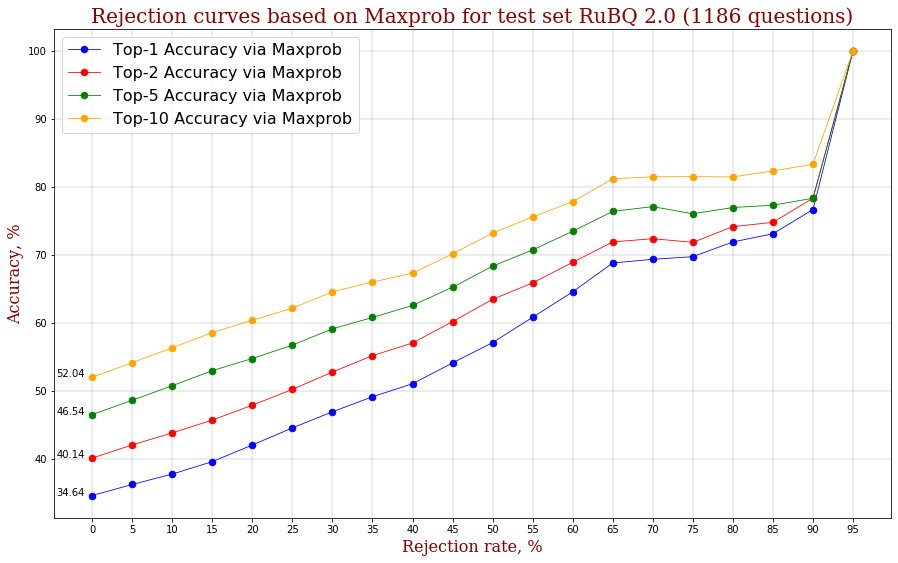

In [256]:
plt.figure(figsize = (15, 9))
plt.title("Rejection curves based on Maxprob for test set RuBQ 2.0 (1186 questions)", fontdict=font_title)

font = {'family': 'serif',
            'color': 'darkred',
            'weight': 'normal',
            'size': 16
            }

font_title = {'family': 'serif',
              'color': 'darkred',
              'weight': 'normal',
              'size': 20
              }

plt.xlabel("Rejection rate, %", fontdict=font)
plt.ylabel("Accuracy, %", fontdict=font)
plt.xticks(ticks=np.arange(0, 100, step=5))
plt.grid(color='black', linewidth=0.15)


plt.plot(100 - np.array(list(accuracy_for_each_topk[:num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[:num_quantiles][0].values())),
         label=f"Top-{1} Accuracy via Maxprob", c="blue", marker='.', markersize=13, linewidth=0.8);

plt.plot(100 - np.array(list(accuracy_for_each_topk[num_quantiles:2*num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[num_quantiles:2*num_quantiles][0].values())),
         label=f"Top-{2} Accuracy via Maxprob", c="red", marker='.', markersize=13, linewidth=0.8);

plt.plot(100 - np.array(list(accuracy_for_each_topk[2*num_quantiles:3*num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[2*num_quantiles:3*num_quantiles][0].values())),
         label=f"Top-{5} Accuracy via Maxprob", c="green", marker='.', markersize=13, linewidth=0.8);

plt.plot(100 - np.array(list(accuracy_for_each_topk[3*num_quantiles:4*num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[3*num_quantiles:4*num_quantiles][0].values())),
         label=f"Top-{10} Accuracy via Maxprob", c="orange", marker='.', markersize=13, linewidth=0.8);


accuracy_on_full_data_top_1 = np.array(list(accuracy_for_each_topk[:num_quantiles][0].values()))[-1]
accuracy_on_full_data_top_2 = np.array(list(accuracy_for_each_topk[num_quantiles:2*num_quantiles][0].values()))[-1]
accuracy_on_full_data_top_5 = np.array(list(accuracy_for_each_topk[2*num_quantiles:3*num_quantiles][0].values()))[-1]
accuracy_on_full_data_top_10 = np.array(list(accuracy_for_each_topk[3*num_quantiles:4*num_quantiles][0].values()))[-1]

plt.annotate("{}".format(np.round(accuracy_on_full_data_top_1, 2)), (0 - 4.5, accuracy_on_full_data_top_1));
plt.annotate("{}".format(np.round(accuracy_on_full_data_top_2, 2)), (0 - 4.5, accuracy_on_full_data_top_2));
plt.annotate("{}".format(np.round(accuracy_on_full_data_top_5, 2)), (0 - 4.5, accuracy_on_full_data_top_5));
plt.annotate("{}".format(np.round(accuracy_on_full_data_top_10, 2)), (0 - 4.5, accuracy_on_full_data_top_10));

plt.legend(fontsize=16);



# Delta

In [262]:
num_quantiles = 20

quants = [thresh / num_quantiles for thresh in range(1, num_quantiles+1)]
deltas = [i[0] - i[1] for i in probas]
thresholds_delta = [np.quantile(deltas, q) for q in quants]
thresholds_delta = thresholds_delta[::-1]

accuracy_for_each_topk = []

#top_k pred
for top_k in [1, 2, 5, 10]:
    
    accuracy_for_each_quantile = {}

    for quantile in range(num_quantiles):

        # list of predictions
        list_of_predictions = list(compress(predictions, deltas >= thresholds_delta[quantile]))
        
        #list of correct answers
        list_of_correct_answers = list(compress(rubq_test_answers[:sample_questions], deltas >= thresholds_delta[quantile]))
        
        # choose top k predictions
        top_k_list_of_predictions = [i[:top_k] for i in list_of_predictions]

        top_k_list_of_predicted_ids= []
        for sample in top_k_list_of_predictions:
            new = []
            for prediction in sample:
                try:
                    x = from_text_to_id(prediction)
                except:
                    x = "None"
                new.append(x)

            top_k_list_of_predicted_ids.append(new)


        right = 0
        for i in range(len(list_of_correct_answers)):
            if any(item in top_k_list_of_predicted_ids[i] for item in list_of_correct_answers[i]):
                right += 1
            else:
                pass

        accuracy = np.round(right/len(list_of_correct_answers), 4)*100
        print(f"Top-{top_k} accuracy on the {(quantile+1)*(int(100/num_quantiles))}% the most confident from the Delta point of view = {accuracy}%")

        accuracy_for_each_quantile[(quantile+1)*(int(100/num_quantiles))] = accuracy
        accuracy_for_each_topk.append(accuracy_for_each_quantile)
        
    print("\n")









Top-1 accuracy on the 5% the most confident from the Delta point of view = 100.0%
Top-1 accuracy on the 10% the most confident from the Delta point of view = 80.0%
Top-1 accuracy on the 15% the most confident from the Delta point of view = 73.11%
Top-1 accuracy on the 20% the most confident from the Delta point of view = 71.91%
Top-1 accuracy on the 25% the most confident from the Delta point of view = 71.85000000000001%
Top-1 accuracy on the 30% the most confident from the Delta point of view = 71.04%
Top-1 accuracy on the 35% the most confident from the Delta point of view = 69.1%
Top-1 accuracy on the 40% the most confident from the Delta point of view = 63.370000000000005%
Top-1 accuracy on the 45% the most confident from the Delta point of view = 59.58%
Top-1 accuracy on the 50% the most confident from the Delta point of view = 56.37%
Top-1 accuracy on the 55% the most confident from the Delta point of view = 54.47%
Top-1 accuracy on the 60% the most confident from the Delta point

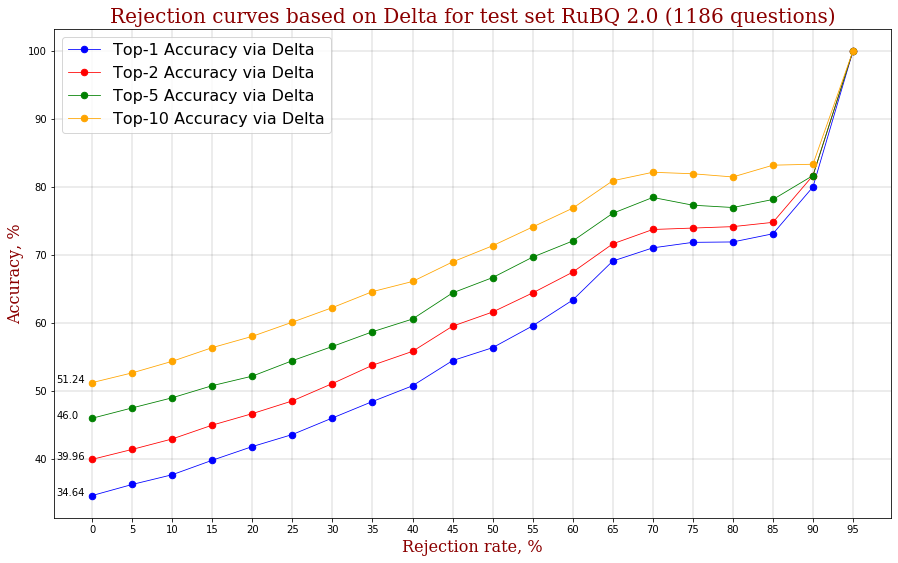

In [263]:
plt.figure(figsize = (15, 9))
plt.title("Rejection curves based on Delta for test set RuBQ 2.0 (1186 questions)", fontdict=font_title)

font = {'family': 'serif',
            'color': 'darkred',
            'weight': 'normal',
            'size': 16
            }

font_title = {'family': 'serif',
              'color': 'darkred',
              'weight': 'normal',
              'size': 20
              }

plt.xlabel("Rejection rate, %", fontdict=font)
plt.ylabel("Accuracy, %", fontdict=font)
plt.xticks(ticks=np.arange(0, 100, step=5))
plt.grid(color='black', linewidth=0.15)


plt.plot(100 - np.array(list(accuracy_for_each_topk[:num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[:num_quantiles][0].values())),
         label=f"Top-{1} Accuracy via Delta", c="blue", marker='.', markersize=13, linewidth=0.8);

plt.plot(100 - np.array(list(accuracy_for_each_topk[num_quantiles:2*num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[num_quantiles:2*num_quantiles][0].values())),
         label=f"Top-{2} Accuracy via Delta", c="red", marker='.', markersize=13, linewidth=0.8);

plt.plot(100 - np.array(list(accuracy_for_each_topk[2*num_quantiles:3*num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[2*num_quantiles:3*num_quantiles][0].values())),
         label=f"Top-{5} Accuracy via Delta", c="green", marker='.', markersize=13, linewidth=0.8);

plt.plot(100 - np.array(list(accuracy_for_each_topk[3*num_quantiles:4*num_quantiles][0].keys())),
         np.array(list(accuracy_for_each_topk[3*num_quantiles:4*num_quantiles][0].values())),
         label=f"Top-{10} Accuracy via Delta", c="orange", marker='.', markersize=13, linewidth=0.8);


accuracy_on_full_data_top_1 = np.array(list(accuracy_for_each_topk[:num_quantiles][0].values()))[-1]
accuracy_on_full_data_top_2 = np.array(list(accuracy_for_each_topk[num_quantiles:2*num_quantiles][0].values()))[-1]
accuracy_on_full_data_top_5 = np.array(list(accuracy_for_each_topk[2*num_quantiles:3*num_quantiles][0].values()))[-1]
accuracy_on_full_data_top_10 = np.array(list(accuracy_for_each_topk[3*num_quantiles:4*num_quantiles][0].values()))[-1]

plt.annotate("{}".format(np.round(accuracy_on_full_data_top_1, 2)), (0 - 4.5, accuracy_on_full_data_top_1));
plt.annotate("{}".format(np.round(accuracy_on_full_data_top_2, 2)), (0 - 4.5, accuracy_on_full_data_top_2));
plt.annotate("{}".format(np.round(accuracy_on_full_data_top_5, 2)), (0 - 4.5, accuracy_on_full_data_top_5));
plt.annotate("{}".format(np.round(accuracy_on_full_data_top_10, 2)), (0 - 4.5, accuracy_on_full_data_top_10));

plt.legend(fontsize=16);



#### Some preparations

In [32]:
num_questions = 50
num_quantiles = 10

res = [topkSample(rubq_test["question"][i], model = t5_qa_model, tokenizer = t5_tok, max_output_length=128, num_beams=1, num_samples = 5) for i in range(num_questions)]
probs_for_examples = [[math.exp(float(j[1])) for j in i] for i in res]
quants = [thresh / num_quantiles for thresh in range(1, num_quantiles+1)]


entropies = [scipy.stats.entropy(i) for i in probs_for_examples]
thresholds_entropy = [np.quantile(entropies, q) for q in quants]

# for 5% -> 0
quantile = 0
list_of_predictions_with_log_scores = list(compress(res, entropies <= thresholds_entropy[quantile]))
list_of_correct_answers = list(compress(rubq_answers,  entropies <= thresholds_entropy[quantile]))
list_of_predictions = [[j[0] for j in i] for i in list_of_predictions_with_log_scores]

list_of_predicted_ids = []
for sample in list_of_predictions:
    new = []
    for prediction in sample:
        try:
            x = from_text_to_id(prediction)
        except:
            x = "None"
        new.append(x)

    list_of_predicted_ids.append(new)
    
    
    

In [40]:
probs_for_examples[0]

[0.053119500258598226,
 3.5508785966658604e-05,
 1.768943428297719e-05,
 5.012966873274316e-06,
 1.7772552668605872e-06]

In [45]:
np.round(probs_for_examples[0], 3)

array([0.053, 0.   , 0.   , 0.   , 0.   ])

In [41]:
scipy.special.softmax(probs_for_examples[0])

array([0.20863221, 0.197846  , 0.19784248, 0.19783997, 0.19783933])

In [20]:
list_of_predicted_ids

[['Q19660', 'Q46852', 'Q168057', 'Q79808', 'Q143079'],
 ['None', 'None', 'None', 'None', 'None'],
 ['Q5513433', 'None', 'None', 'None', 'None'],
 ['Q174044', 'Q726105', 'Q19002866', 'None', 'None'],
 ['Q1850', 'Q1854', 'Q1854', 'Q1850', 'Q19675'],
 ['Q83406', 'Q43718', 'Q524085', 'Q335064', 'None'],
 ['Q43718', 'Q7996', 'Q923', 'Q31034308', 'None'],
 ['Q830561', 'None', 'None', 'None', 'None'],
 ['Q704832', 'Q5794774', 'Q659592', 'None', 'None'],
 ['None', 'None', 'None', 'None', 'None'],
 ['None', 'Q4590630', 'None', 'None', 'Q4884552'],
 ['Q15180', 'Q46118', 'None', 'None', 'None'],
 ['Q394963', 'None', 'Q914218', 'None', 'None'],
 ['Q184535', 'None', 'None', 'None', 'None'],
 ['Q122263', 'Q2918819', 'Q2576', 'None', 'None'],
 ['Q3427', 'Q313', 'Q793510', 'Q5598740', 'None'],
 ['Q409760', 'None', 'None', 'Q318657', 'None'],
 ['Q630823', 'Q2650702', 'Q917829', 'Q4051134', 'None'],
 ['Q62272', 'None', 'None', 'None', 'None'],
 ['Q153319', 'None', 'None', 'None', 'None'],
 ['Q7200', 'Q7

In [21]:
list_of_correct_answers

[['Q19660'],
 ['Q312480'],
 ['Q43'],
 ['Q49481'],
 ['Q1850'],
 ['Q1860923'],
 ['Q57966'],
 ['Q128790'],
 ['Q11419'],
 ['Q172911'],
 ['Q891'],
 ['Q790'],
 ['Q149067'],
 ['Q395', 'Q7754', 'Q41217', 'Q149999', 'Q56114489'],
 ['Q157623'],
 ['Q10484'],
 ['Q130498'],
 ['Q1918252'],
 ['Q739362'],
 ['Q240150'],
 ['Q192239', 'Q12799318'],
 ['Q4872'],
 ['Q1369676'],
 ['Q130531'],
 ['Q42831'],
 ['Q762'],
 ['Q162737'],
 ['Q320653'],
 ['Q8006'],
 ['Q715281'],
 ['Q267861', 'Q1323788'],
 ['Q269668'],
 ['Q912050', 'Q2453629'],
 ['Q69060'],
 ['Q182101'],
 ['Q711'],
 ['Q167997'],
 ['Q204138'],
 ['Q236132', 'Q456257'],
 ['Q17714']]

In [30]:
#top k accuracy
top_k = 5

right=0
for number_of_question, prediction in enumerate(list_of_predicted_ids):
    print("prediction:", prediction)
    top_k_preds = prediction[:top_k]
    print("top_k_preds:", top_k_preds)
    print("correct prediction", list_of_correct_answers[number_of_question])
    if any(item in top_k_preds for item in list_of_correct_answers[number_of_question]):
        right += 1
    else:
        pass
    
accuracy = np.round(right/len(list_of_predicted_ids), 2)*100
print(f"top {top_k} accuracy on the most certain by entropy {10*(quantile+1)}% quantile = ", accuracy)



prediction: ['Q19660', 'Q46852', 'Q168057', 'Q79808', 'Q143079']
top_k_preds: ['Q19660', 'Q46852', 'Q168057', 'Q79808', 'Q143079']
correct prediction ['Q19660']
prediction: ['None', 'None', 'None', 'None', 'None']
top_k_preds: ['None', 'None', 'None', 'None', 'None']
correct prediction ['Q312480']
prediction: ['Q5513433', 'None', 'None', 'None', 'None']
top_k_preds: ['Q5513433', 'None', 'None', 'None', 'None']
correct prediction ['Q43']
prediction: ['Q174044', 'Q726105', 'Q19002866', 'None', 'None']
top_k_preds: ['Q174044', 'Q726105', 'Q19002866', 'None', 'None']
correct prediction ['Q49481']
prediction: ['Q1850', 'Q1854', 'Q1854', 'Q1850', 'Q19675']
top_k_preds: ['Q1850', 'Q1854', 'Q1854', 'Q1850', 'Q19675']
correct prediction ['Q1850']
prediction: ['Q83406', 'Q43718', 'Q524085', 'Q335064', 'None']
top_k_preds: ['Q83406', 'Q43718', 'Q524085', 'Q335064', 'None']
correct prediction ['Q1860923']
prediction: ['Q43718', 'Q7996', 'Q923', 'Q31034308', 'None']
top_k_preds: ['Q43718', 'Q7996',

In [31]:
right

3

In [81]:
any(item in [4, 5] for item in [1, 5, 2, 3])

True

# 2) Experiments with baseline accuracy for different models (t5-3b-ssm, t5-3b-ssm-nq, t5-3b-ssm-nqo, t5-xl-ssm-nq)

# SQ test T5-3b model QA

In [26]:
sq_test_data = np.load("simple_questions_test.npy")

In [40]:
questions = sq_test_data[:,3]


In [41]:
answers = []
for i in tqdm(range(len(questions))):
    input_ids = t5_tok(questions[i], return_tensors="pt").input_ids
    input_ids = input_ids.to(device)
    gen_output = t5_qa_model.generate(input_ids)[0]
    answers.append(gen_output)
    
    
preds_sq = []
for x in answers:
    preds_sq.append(t5_tok.decode(x, skip_special_tokens=True))


100%|██████████| 4751/4751 [23:36<00:00,  3.35it/s]


In [44]:
preds_id_sq = []
for i in range(len(preds_sq)):
    try:
        x = from_text_to_id(preds_sq[i])
    except:
        x = "None"
    
    preds_id_sq.append(x)

In [51]:
right_sq = 0
for i in tqdm(range(len(preds_id_sq))):
    if preds_id_sq[i] == sq_test_data[i,2]:
        right_sq += 1
    else:
        pass

100%|██████████| 4751/4751 [00:00<00:00, 275339.40it/s]


In [53]:
right_sq/len(preds_id_sq)

0.01768048831824879

In [67]:
#np.save("predictions_sq_test_t5_3b_vanilla.npy", np.array(preds_sq))

## SQ another model

In [ ]:
def check_t5_sq(t5_tok, t5_qa_model):
    
    sq_test_data = np.load("simple_questions_test.npy")
    questions = sq_test_data[:,3]


    answers = []
    for i in tqdm(range(len(questions))):
        input_ids = t5_tok(questions[i], return_tensors="pt").input_ids
        input_ids = input_ids.to(device)
        gen_output = t5_qa_model.generate(input_ids)[0]
        answers.append(gen_output)


    preds_sq = []
    for x in answers:
        preds_sq.append(t5_tok.decode(x, skip_special_tokens=True))


    preds_id_sq = []
    for i in range(len(preds_sq)):
        try:
            x = from_text_to_id(preds_sq[i])
        except:
            x = "None"

        preds_id_sq.append(x)

    right_sq = 0
    for i in tqdm(range(len(preds_id_sq))):
        if preds_id_sq[i] == sq_test_data[i,2]:
            right_sq += 1
        else:
            pass

    acc = right_sq/len(preds_id_sq)
    
    return acc, preds_id_sq

In [5]:
t5_qa_model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-3b-ssm-nq")#"google/t5-11b-ssm-tqa")
t5_tok = AutoTokenizer.from_pretrained("google/t5-3b-ssm-nq")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
t5_qa_model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
             

In [6]:
acc, preds_id_sq = check_t5_sq(t5_tok = t5_tok,
                               t5_qa_model = t5_qa_model)

100%|██████████| 4751/4751 [00:00<00:00, 852716.77it/s]


In [7]:
print("top1 accuracy = ", acc)

top1 accuracy =  0.06819616922753105


In [12]:
np.load("simple_questions_test.npy")

array([['Q7358590', 'P20', 'Q1637790', 'Where did roger marquis die?'],
       ['Q154335', 'P509', 'Q12152',
        'what was the cause of death of yves klein?'],
       ['Q62498', 'P21', 'Q6581097',
        'how does engelbert zaschka identify?'],
       ...,
       ['Q7142651', 'P495', 'Q145',
        'which country filmed passing shadows?'],
       ['Q445899', 'P19', 'Q1748',
        'Where was gunnar johansen born in Denmark??'],
       ['Q582715', 'P31', 'Q3863',
        'what celestial object is 2974 holden?']], dtype='<U101')

## rubq

In [8]:
t5_qa_model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-3b-ssm-nq")#"google/t5-11b-ssm-tqa")
t5_tok = AutoTokenizer.from_pretrained("google/t5-3b-ssm-nq")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
t5_qa_model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
             

In [9]:
rubq_test = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")

answers = []
for i in tqdm(range(len(rubq_test))):
    input_ids = t5_tok(rubq_test[i], return_tensors="pt").input_ids
    input_ids = input_ids.to(device)
    gen_output = t5_qa_model.generate(input_ids)[0]
    answers.append(gen_output)
    
    
final = []
for x in answers:
    final.append(t5_tok.decode(x, skip_special_tokens=True))

    
#rubq_questions = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")
entities_test_rubq = np.load("entities_test_rubq.npy")
rubq_test = pd.DataFrame({"subject":entities_test_rubq, "question":rubq_test})
rubq_test_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)

# answers_rubq = []

# for lis in rubq_test_answers:
#     print(lis)
#     new = []
#     for element in lis:
#         new.append(get_description_name(element))

#     answers_rubq.append(new)
    
preds = []
for i in range(len(final)):
    try:
        x = from_text_to_id(final[i])
    except:
        x = "None"
    
    preds.append(x)
    
np.save("predictions_rubq_test_t5_3b_ssm_nq.npy", np.array(final))

answers_rubq = []

for lis in rubq_test_answers:
    print(lis)
    new = []
    for element in lis:
        new.append(element)

    answers_rubq.append(new)

right = 0

for i, ans in enumerate(answers_rubq):
    if preds[i] in ans:
        right += 1
    else:
        pass
    
print(f"Accuracy = {right/len(preds)}")

100%|██████████| 1186/1186 [03:03<00:00,  6.46it/s]


['Q7944', 'Q60186', 'Q167903', 'Q2580904', 'Q5975740', 'Q7692360']
['Q102513']
['Q692']
['Q19660']
['Q6607', 'Q483994', 'Q626035', 'Q2643890', 'Q17172850']
['Q142']
['Q299687']
['Q312480']
['Q29']
['Q4022']
['Q796']
['Q38768', 'Q201605', 'Q1676638']
['Q22']
['Q11420', 'Q106500']
['Q4808485']
['Q2838011']
['Q9299872']
['Q2674728']
['Q1968651']
['Q1088']
['Q7737', 'Q29561']
['Q36124']
['Q43']
['Q49481']
['Q424', 'Q869', 'Q881']
['Q148', 'Q837']
['Q232']
['Q408']
['Q816']
['Q847', 'Q5377']
['Q30']
['Q1792']
['Q822290']
['Q1603']
['Q181306', 'Q213344', 'Q237367', 'Q1326237']
['Q237800']
['Q106151']
['Q201598']
['Q223134']
['Q106010']
['Q29445']
['Q40591', 'Q58784', 'Q295347', 'Q470600']
['Q1850']
['Q4719']
['Q157683']
['Q158491']
['Q62']
['Q24861']
['Q3787']
['Q8338', 'Q202027', 'Q17172850']
['Q55']
['Q19675']
['Q36180', 'Q82955', 'Q185351', 'Q333634', 'Q1209498', 'Q1297719', 'Q4964182', 'Q11774202', 'Q18814623']
['Q22']
['Q1048']
['Q9191']
['Q687']
['Q1860923']
['Q178577']
['Q199588']
['Q

# t5-3b-ssm-nqo

In [5]:
t5_qa_model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-3b-ssm-nqo")#"google/t5-11b-ssm-tqa")
t5_tok = AutoTokenizer.from_pretrained("google/t5-3b-ssm-nqo")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
t5_qa_model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
             

In [6]:
acc_o, preds_id_sq_o = check_t5_sq(t5_tok = t5_tok, t5_qa_model = t5_qa_model)

100%|██████████| 4751/4751 [00:00<00:00, 827298.47it/s]


In [7]:
print("top1 accuracy t5-3b-ssm-nqo SQ = ", acc_o)

top1 accuracy t5-3b-ssm-nqo SQ =  0.06735424121237635


In [8]:
rubq_test = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")

answers = []
for i in tqdm(range(len(rubq_test))):
    input_ids = t5_tok(rubq_test[i], return_tensors="pt").input_ids
    input_ids = input_ids.to(device)
    gen_output = t5_qa_model.generate(input_ids)[0]
    answers.append(gen_output)
    
    
final = []
for x in answers:
    final.append(t5_tok.decode(x, skip_special_tokens=True))

    
#rubq_questions = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")
entities_test_rubq = np.load("entities_test_rubq.npy")
rubq_test = pd.DataFrame({"subject":entities_test_rubq, "question":rubq_test})
rubq_test_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)

# answers_rubq = []

# for lis in rubq_test_answers:
#     print(lis)
#     new = []
#     for element in lis:
#         new.append(get_description_name(element))

#     answers_rubq.append(new)
    
preds = []
for i in range(len(final)):
    try:
        x = from_text_to_id(final[i])
    except:
        x = "None"
    
    preds.append(x)
    
np.save("predictions_rubq_test_t5_3b_ssm_nq.npy", np.array(final))

answers_rubq = []

for lis in rubq_test_answers:
    print(lis)
    new = []
    for element in lis:
        new.append(element)

    answers_rubq.append(new)

right = 0

for i, ans in enumerate(answers_rubq):
    if preds[i] in ans:
        right += 1
    else:
        pass
    
print(f"top1 accuracy t5-3b-ssm-nqo RuBQ =  = {right/len(preds)}")

100%|██████████| 1186/1186 [03:13<00:00,  6.14it/s]


['Q7944', 'Q60186', 'Q167903', 'Q2580904', 'Q5975740', 'Q7692360']
['Q102513']
['Q692']
['Q19660']
['Q6607', 'Q483994', 'Q626035', 'Q2643890', 'Q17172850']
['Q142']
['Q299687']
['Q312480']
['Q29']
['Q4022']
['Q796']
['Q38768', 'Q201605', 'Q1676638']
['Q22']
['Q11420', 'Q106500']
['Q4808485']
['Q2838011']
['Q9299872']
['Q2674728']
['Q1968651']
['Q1088']
['Q7737', 'Q29561']
['Q36124']
['Q43']
['Q49481']
['Q424', 'Q869', 'Q881']
['Q148', 'Q837']
['Q232']
['Q408']
['Q816']
['Q847', 'Q5377']
['Q30']
['Q1792']
['Q822290']
['Q1603']
['Q181306', 'Q213344', 'Q237367', 'Q1326237']
['Q237800']
['Q106151']
['Q201598']
['Q223134']
['Q106010']
['Q29445']
['Q40591', 'Q58784', 'Q295347', 'Q470600']
['Q1850']
['Q4719']
['Q157683']
['Q158491']
['Q62']
['Q24861']
['Q3787']
['Q8338', 'Q202027', 'Q17172850']
['Q55']
['Q19675']
['Q36180', 'Q82955', 'Q185351', 'Q333634', 'Q1209498', 'Q1297719', 'Q4964182', 'Q11774202', 'Q18814623']
['Q22']
['Q1048']
['Q9191']
['Q687']
['Q1860923']
['Q178577']
['Q199588']
['Q

# google/t5-xl-ssm-nq

In [9]:
!nvidia-cdl

Driver version: 510.85.02
------------------- Device 0 -------------------
Name: NVIDIA GeForce RTX 3090 Ti
Memory usage:  4407MiB / 24564MiB
Temperature: 20C
Running processes not found

------------------- Device 1 -------------------
Name: NVIDIA GeForce RTX 3090 Ti
Memory usage: 12387MiB / 24564MiB
Temperature: 20C
Running processes not found

------------------- Device 2 -------------------
Name: NVIDIA GeForce RTX 3090 Ti
Memory usage: 13837MiB / 24564MiB
Temperature: 32C
Running processes not found

------------------- Device 3 -------------------
Name: NVIDIA GeForce RTX 3090 Ti
Memory usage:   316MiB / 24564MiB
Temperature: 21C
Running processes not found

------------------- Device 4 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:  9196MiB / 11264MiB
Temperature: 21C
Running processes not found

------------------- Device 5 -------------------
Name: NVIDIA GeForce RTX 2080 Ti
Memory usage:  9188MiB / 11264MiB
Temperature: 21C
Running processes not found



In [10]:
t5_qa_model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-xl-ssm-nq")#"google/t5-11b-ssm-tqa")
t5_tok = AutoTokenizer.from_pretrained("google/t5-xl-ssm-nq")
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
t5_qa_model.to(device)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.4G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 2048)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 2048)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=2048, out_features=2048, bias=False)
              (k): Linear(in_features=2048, out_features=2048, bias=False)
              (v): Linear(in_features=2048, out_features=2048, bias=False)
              (o): Linear(in_features=2048, out_features=2048, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedGeluDense(
              (wi_0): Linear(in_features=2048, out_features=5120, bias=False)
              (wi_1): Linear(in_features=2048, out_features=5120, bias=False)
      

In [11]:
acc_o, preds_id_sq_o = check_t5_sq(t5_tok = t5_tok, t5_qa_model = t5_qa_model)

100%|██████████| 4751/4751 [00:00<00:00, 811101.36it/s]


In [12]:
print("top1 accuracy t5-xl-ssm-nq SQ = ", acc_o)

top1 accuracy t5-xl-ssm-nq SQ =  0.07472111134498001


In [13]:
rubq_test = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")

answers = []
for i in tqdm(range(len(rubq_test))):
    input_ids = t5_tok(rubq_test[i], return_tensors="pt").input_ids
    input_ids = input_ids.to(device)
    gen_output = t5_qa_model.generate(input_ids)[0]
    answers.append(gen_output)
    
    
final = []
for x in answers:
    final.append(t5_tok.decode(x, skip_special_tokens=True))

    
#rubq_questions = np.load("all_EN_rubq_test_questions_1_hop_uri.npy")
entities_test_rubq = np.load("entities_test_rubq.npy")
rubq_test = pd.DataFrame({"subject":entities_test_rubq, "question":rubq_test})
rubq_test_answers = np.load("all_rubq_test_answers_1_hop_uri.npy", allow_pickle=True)

# answers_rubq = []

# for lis in rubq_test_answers:
#     print(lis)
#     new = []
#     for element in lis:
#         new.append(get_description_name(element))

#     answers_rubq.append(new)
    
preds = []
for i in range(len(final)):
    try:
        x = from_text_to_id(final[i])
    except:
        x = "None"
    
    preds.append(x)
    
np.save("predictions_rubq_test_t5_3b_ssm_nq.npy", np.array(final))

answers_rubq = []

for lis in rubq_test_answers:
    print(lis)
    new = []
    for element in lis:
        new.append(element)

    answers_rubq.append(new)

right = 0

for i, ans in enumerate(answers_rubq):
    if preds[i] in ans:
        right += 1
    else:
        pass
    
print(f"top1 accuracy t5-xl-ssm-nq RuBQ =  = {right/len(preds)}")

100%|██████████| 1186/1186 [02:57<00:00,  6.68it/s]


['Q7944', 'Q60186', 'Q167903', 'Q2580904', 'Q5975740', 'Q7692360']
['Q102513']
['Q692']
['Q19660']
['Q6607', 'Q483994', 'Q626035', 'Q2643890', 'Q17172850']
['Q142']
['Q299687']
['Q312480']
['Q29']
['Q4022']
['Q796']
['Q38768', 'Q201605', 'Q1676638']
['Q22']
['Q11420', 'Q106500']
['Q4808485']
['Q2838011']
['Q9299872']
['Q2674728']
['Q1968651']
['Q1088']
['Q7737', 'Q29561']
['Q36124']
['Q43']
['Q49481']
['Q424', 'Q869', 'Q881']
['Q148', 'Q837']
['Q232']
['Q408']
['Q816']
['Q847', 'Q5377']
['Q30']
['Q1792']
['Q822290']
['Q1603']
['Q181306', 'Q213344', 'Q237367', 'Q1326237']
['Q237800']
['Q106151']
['Q201598']
['Q223134']
['Q106010']
['Q29445']
['Q40591', 'Q58784', 'Q295347', 'Q470600']
['Q1850']
['Q4719']
['Q157683']
['Q158491']
['Q62']
['Q24861']
['Q3787']
['Q8338', 'Q202027', 'Q17172850']
['Q55']
['Q19675']
['Q36180', 'Q82955', 'Q185351', 'Q333634', 'Q1209498', 'Q1297719', 'Q4964182', 'Q11774202', 'Q18814623']
['Q22']
['Q1048']
['Q9191']
['Q687']
['Q1860923']
['Q178577']
['Q199588']
['Q

In [23]:
torch.cuda.empty_cache()